## データセットの準備

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
def space_clean(row):
    row = row.replace(". ", "").replace(" .", "").replace("  ", " ")
    return row


def canonicalize(smiles):
    try:
        new_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    except:
        new_smiles = None
    return new_smiles

In [ ]:
df = pd.read_csv("data/NiB/inchi_23l_reaction_t5_ready.csv")

In [4]:
# 必須カラムの存在チェックと補完
required_cols = ["REACTANT", "CATALYST", "REAGENT", "SOLVENT", "PRODUCT"]
for col in required_cols:
    if col not in df.columns:
        df[col] = ""

# 必要に応じてYIELDを標準化（0-1に正規化）
if "YIELD" in df.columns and df["YIELD"].max() >= 100:
    df["YIELD"] = df["YIELD"].clip(0, 100) / 100
else:
    df["YIELD"] = None

In [5]:
for col in ["REAGENT", "REACTANT", "PRODUCT"]:
    df[col] = df[col].apply(space_clean)
    df[col] = df[col].apply(lambda x: canonicalize(x) if x != " " else " ")
    df = df[~df[col].isna()].reset_index(drop=True)
    df[col] = df[col].apply(lambda x: ".".join(sorted(x.split("."))))

In [6]:
df["REAGENT"] = df["CATALYST"].fillna(" ") + "." + df["REAGENT"].fillna(" ") + "." + df["SOLVENT"].fillna(" ") 

## モデルの読み込み

In [7]:
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5ForConditionalGeneration, AutoConfig, PreTrainedModel

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

/root/ReactionT5-bo-yield/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
class ReactionT5Yield(PreTrainedModel):
    config_class  = AutoConfig
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.model = T5ForConditionalGeneration.from_pretrained(self.config._name_or_path)
        self.model.resize_token_embeddings(self.config.vocab_size)
        self.fc1 = nn.Linear(self.config.hidden_size, self.config.hidden_size//2)
        self.fc2 = nn.Linear(self.config.hidden_size, self.config.hidden_size//2)
        self.fc3 = nn.Linear(self.config.hidden_size//2*2, self.config.hidden_size)
        self.fc4 = nn.Linear(self.config.hidden_size, self.config.hidden_size)
        self.fc5 = nn.Linear(self.config.hidden_size, 1)

        self._init_weights(self.fc1)
        self._init_weights(self.fc2)
        self._init_weights(self.fc3)
        self._init_weights(self.fc4)
        self._init_weights(self.fc5)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, inputs):
        device = inputs['input_ids'].device

        with torch.no_grad():
            encoder_outputs = self.model.encoder(
                input_ids=inputs['input_ids'],
                attention_mask=inputs.get('attention_mask', None),
            )
            encoder_hidden_states = encoder_outputs[0]  # (B, L, H)

            dec_input_ids = torch.full(
                (inputs['input_ids'].size(0), 1),
                self.config.decoder_start_token_id,
                dtype=torch.long,
                device=device,
            )

            outputs = self.model.decoder(
                input_ids=dec_input_ids,
                encoder_hidden_states=encoder_hidden_states,
            )
            last_hidden_states = outputs[0]  # (B, 1, H)

        output1 = self.fc1(last_hidden_states.view(-1, self.config.hidden_size))
        output2 = self.fc2(encoder_hidden_states[:, 0, :].view(-1, self.config.hidden_size))
        output = self.fc3(torch.hstack((output1, output2)))
        output = self.fc4(output)
        output = self.fc5(output)
        return output * 100

In [9]:
# 収率予測（スカラー出力）
yield_tokenizer = AutoTokenizer.from_pretrained("sagawa/ReactionT5v2-yield")
yield_model = ReactionT5Yield.from_pretrained("sagawa/ReactionT5v2-yield")

In [10]:
# Dropoutレイヤーを学習モードに設定する関数
def enable_dropout(model):
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()

In [11]:
# MC Dropoutによる推論
def mc_dropout_inference(model, tokenizer, reaction_smiles, n_samples=10, max_length=512, batch_size=64):
    model.eval()  # まずモデル全体を評価モードに
    enable_dropout(model)  # Dropoutレイヤーのみ学習モードに
    
    # GPUが利用可能かチェック
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # 単一の文字列の場合リストに変換
    if isinstance(reaction_smiles, str):
        reaction_smiles = [reaction_smiles]
    
    predictions = []
    
    with torch.no_grad():
        for sample_idx in range(n_samples):
            batch_predictions = []
            
            # バッチごとに処理
            for i in range(0, len(reaction_smiles), batch_size):
                batch_smiles = reaction_smiles[i:i + batch_size]
                
                # バッチトークン化
                inputs = tokenizer(
                    batch_smiles, 
                    return_tensors="pt", 
                    max_length=max_length,
                    padding=True,
                    truncation=True
                ).to(device)
                
                # バッチ予測実行
                outputs = model(inputs)
                batch_predictions.extend(outputs.cpu().numpy().flatten())
            
            predictions.append(np.array(batch_predictions))
    
    # 結果を配列に変換: (n_samples, n_reactions)
    predictions = np.array(predictions)
    
    # 統計量計算
    mean_pred = np.mean(predictions, axis=0)
    var_pred = np.var(predictions, axis=0)
    
    if len(reaction_smiles) == 1:
        return {
            'mean': float(mean_pred[0]),
            'variance': float(var_pred[0])
        }
    else:
        return {
            'mean': mean_pred.tolist(),
            'variance': var_pred.tolist()
        }

## ベイズ最適化

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

In [13]:
# 辞書作成関数
def create_reaction_dictionaries(df):
    """
    データセットから反応辞書を作成
    
    Returns:
        tuple: (reactant_list, reagent_list, product_list, product_dict, true_yield_dict)
    """
    reactant_list = sorted(df["REACTANT"].unique())
    reagent_list = sorted(df["REAGENT"].unique())
    product_list = sorted(df["PRODUCT"].unique())
    
    # (reactant, reagent) -> product のマッピング
    product_dict = {
        (row["REACTANT"], row["REAGENT"]): row["PRODUCT"]
        for _, row in df.iterrows()
    }
    
    # (reactant, reagent, product) -> yield のマッピング
    true_yield_dict = {
        (row["REACTANT"], row["REAGENT"], row["PRODUCT"]): row["YIELD"]
        for _, row in df.iterrows()
    }
    
    print(f"Reactant candidates: {len(reactant_list)}")
    print(f"Reagent candidates: {len(reagent_list)}")
    print(f"Product candidates: {len(product_list)}")
    print(f"Known combinations: {len(product_dict)}")
    
    return reactant_list, reagent_list, product_list, product_dict, true_yield_dict

In [14]:
class BayesianOptimizationWithMCDropout:
    def __init__(self, model, tokenizer, reactant_list, reagent_list, product_dict, true_yield_dict, n_mc_samples=10, batch_size=64):
        """
        MC Dropoutを使用したベイズ最適化（reactant-reagent組み合わせ探索）
        
        Args:
            model: 学習済みReactionT5Yieldモデル
            tokenizer: トークナイザー
            reactant_list: reactantの候補リスト
            reagent_list: reagentの候補リスト
            product_dict: (reactant, reagent) -> product のマッピング辞書
            true_yield_dict: (reactant, reagent, product) -> yield のマッピング辞書
            n_mc_samples: MC Dropoutのサンプル数
            batch_size: バッチ処理のサイズ
        """
        self.model = model
        self.tokenizer = tokenizer
        self.reactant_list = reactant_list
        self.reagent_list = reagent_list
        self.product_dict = product_dict
        self.true_yield_dict = true_yield_dict
        self.n_mc_samples = n_mc_samples
        self.batch_size = batch_size
        
        # 全ての有効な組み合わせを事前計算
        self.valid_combinations = []
        for reactant in reactant_list:
            for reagent in reagent_list:
                if (reactant, reagent) in product_dict:
                    self.valid_combinations.append((reactant, reagent))
        
        print(f"有効な組み合わせ数: {len(self.valid_combinations)}")
        
        # 実験結果の記録
        self.experiment_history = []
        self.tried_combinations = set()
    
    def _predict_yield_with_uncertainty(self, reaction_smiles_list):
        """バッチでのMC Dropout収率予測"""
        result = mc_dropout_inference(
            self.model, self.tokenizer, reaction_smiles_list, 
            n_samples=self.n_mc_samples, batch_size=self.batch_size
        )
        return result['mean'], result['variance']
    
    def _acquisition_function(self, mean, variance, best_observed_yield, xi=0.01):
        """期待改善量（Expected Improvement）による獲得関数"""
        if isinstance(variance, (list, np.ndarray)):
            # バッチ処理の場合
            variance = np.array(variance)
            mean = np.array(mean)
            mask = variance <= 0
            if np.any(mask):
                variance[mask] = 1e-8  # 小さな値で置き換え
            
            std = np.sqrt(variance)
            z = (mean - best_observed_yield - xi) / std
            ei = (mean - best_observed_yield - xi) * norm.cdf(z) + std * norm.pdf(z)
            return ei
        else:
            # 単一値処理の場合
            if variance <= 0:
                return 0.0
            
            std = np.sqrt(variance)
            z = (mean - best_observed_yield - xi) / std
            ei = (mean - best_observed_yield - xi) * norm.cdf(z) + std * norm.pdf(z)
            return ei
    
    def _get_best_observed_yield(self):
        """これまでの最良収率を取得"""
        if len(self.experiment_history) > 0:
            return max([exp['actual_yield'] for exp in self.experiment_history])
        else:
            return 0.0
    
    def _select_next_candidate(self, batch_size=32):
        """バッチ処理で獲得関数に基づいて次の候補を選択"""
        # 未試行の組み合わせを取得
        untried_combinations = [
            combo for combo in self.valid_combinations 
            if combo not in self.tried_combinations
        ]
        
        if not untried_combinations:
            print("全ての組み合わせを試行済みです。")
            return None
        
        # 獲得関数を計算
        best_yield = self._get_best_observed_yield()
        
        # 反応SMILESのリストを作成
        reaction_smiles_list = []
        for reactant, reagent in untried_combinations:
            product = self.product_dict[(reactant, reagent)]
            reaction_smiles = f"REACTANT:{reactant}REAGENT:{reagent}PRODUCT:{product}"
            reaction_smiles_list.append(reaction_smiles)
        
        print(f"獲得関数値を計算中... ({len(reaction_smiles_list)}個の候補)")
        
        try:
            # バッチで予測実行
            pred_means, pred_variances = self._predict_yield_with_uncertainty(reaction_smiles_list)
            
            # 獲得関数値を計算
            acq_values = self._acquisition_function(pred_means, pred_variances, best_yield)
            
            # 結果をまとめる
            acquisition_scores = []
            for i, (combo, mean, var, acq) in enumerate(zip(untried_combinations, pred_means, pred_variances, acq_values)):
                acquisition_scores.append({
                    'combination': combo,
                    'acquisition_value': float(acq),
                    'predicted_mean': float(mean),
                    'predicted_variance': float(var)
                })
            
        except Exception as e:
            print(f"❌ Error in batch prediction: {e}")
            # エラー時はランダム選択
            combo = np.random.choice(len(untried_combinations))
            return untried_combinations[combo]
        
        if not acquisition_scores:
            # 獲得関数が計算できない場合はランダム選択
            combo = np.random.choice(len(untried_combinations))
            return untried_combinations[combo]
        
        # 獲得関数値でソート
        acquisition_scores.sort(key=lambda x: x['acquisition_value'], reverse=True)
        
        #最高獲得関数値を選択
        selected = acquisition_scores[0]
        print(f"🎯 Exploitation: {selected['combination']} (EI: {selected['acquisition_value']:.4f})")
        
        return selected['combination']
    
    def _evaluate_candidate(self, reactant, reagent, trial_num):
        """候補を評価（実験を実行）"""
        product = self.product_dict[(reactant, reagent)]
        reaction_smiles = f"REACTANT:{reactant}REAGENT:{reagent}PRODUCT:{product}"
        
        # MC Dropoutによる予測
        try:
            pred_mean, pred_variance = self._predict_yield_with_uncertainty(reaction_smiles)
        except Exception as e:
            print(f"❌ Prediction error: {e}")
            return None
        
        # 実際の収率を取得
        key = (reactant, reagent, product)
        actual_yield = self.true_yield_dict.get(key)
        
        if actual_yield is None:
            print(f"❗ No ground truth for: {reactant} + {reagent} → {product}")
            actual_yield_pct = 0.0
        else:
            actual_yield_pct = actual_yield * 100  # パーセント変換
        
        # 獲得関数の計算
        best_yield = self._get_best_observed_yield()
        acquisition_value = self._acquisition_function(pred_mean, pred_variance, best_yield)
        
        # 誤差の計算
        error_pct = pred_mean - actual_yield_pct if actual_yield is not None else None
        
        # 実験結果を記録
        experiment_result = {
            'trial': trial_num,
            'reactant': reactant,
            'reagent': reagent,
            'product': product,
            'reaction_smiles': reaction_smiles,
            'predicted_mean': pred_mean,
            'predicted_variance': pred_variance,
            'actual_yield': actual_yield_pct,
            'error_pct': error_pct,
            'acquisition_value': acquisition_value
        }
        
        # 出力
        print(f"🔎 Trial {trial_num}: {reactant} + {reagent} → {product}")
        print(f"   📈 Predicted: {pred_mean:.2f}% ± {np.sqrt(pred_variance):.2f}%")
        print(f"   🧪 Ground truth: {actual_yield_pct:.2f}%" if actual_yield is not None else "   🧪 Ground truth: None")
        if error_pct is not None:
            print(f"   ❗ Error: {error_pct:+.2f}%")
        print(f"   🎯 Acquisition: {acquisition_value:.4f}")
        
        return experiment_result
    
    def optimize(self, n_trials=50):
        """ベイズ最適化の実行"""
        print(f"ベイズ最適化を開始 ({n_trials}試行)")
        print("="*60)
        
        for trial in range(1, n_trials + 1):
            # 次の候補を選択
            candidate = self._select_next_candidate()
            if candidate is None:
                print("全ての組み合わせを試行完了。")
                break
            
            reactant, reagent = candidate
            
            # 候補を評価
            result = self._evaluate_candidate(reactant, reagent, trial)
            if result is None:
                continue
            
            # 結果を記録
            self.experiment_history.append(result)
            self.tried_combinations.add((reactant, reagent))
            
            # 進捗表示
            current_best = max([exp['actual_yield'] for exp in self.experiment_history])
            print(f"   💡 Current best: {current_best:.2f}%")
            print("-" * 60)
        
        print(f"\n最適化完了! 総試行数: {len(self.experiment_history)}")
        
        # 最終結果
        if self.experiment_history:
            best_exp = max(self.experiment_history, key=lambda x: x['actual_yield'])
            print(f"🏆 最高収率: {best_exp['actual_yield']:.2f}%")
            print(f"🏆 最適組み合わせ: {best_exp['reactant']} + {best_exp['reagent']} → {best_exp['product']}")
            return best_exp
        else:
            return None
    
    def get_best_experiments(self, top_k=5):
        """上位k個の実験結果を取得"""
        sorted_experiments = sorted(
            self.experiment_history, 
            key=lambda x: x['actual_yield'], 
            reverse=True
        )
        return sorted_experiments[:top_k]
    
    def get_optimization_summary(self):
        """最適化の概要統計を取得"""
        if not self.experiment_history:
            return {}
        
        actual_yields = [exp['actual_yield'] for exp in self.experiment_history]
        predicted_means = [exp['predicted_mean'] for exp in self.experiment_history]
        errors = [exp['error_pct'] for exp in self.experiment_history if exp['error_pct'] is not None]
        
        return {
            'total_trials': len(self.experiment_history),
            'max_yield': max(actual_yields),
            'mean_yield': np.mean(actual_yields),
            'std_yield': np.std(actual_yields),
            'mae_error': np.mean(np.abs(errors)) if errors else None,
            'rmse_error': np.sqrt(np.mean(np.array(errors)**2)) if errors else None,
            'coverage': len(self.tried_combinations) / len(self.valid_combinations) * 100
        }

In [15]:
# 辞書の作成
reactant_list, reagent_list, product_list, product_dict, true_yield_dict = create_reaction_dictionaries(df)

# ベイズ最適化器を初期化
optimizer = BayesianOptimizationWithMCDropout(
    model=yield_model,
    tokenizer=yield_tokenizer,
    reactant_list=reactant_list,
    reagent_list=reagent_list,
    product_dict=product_dict,
    true_yield_dict=true_yield_dict,
    n_mc_samples=10,
    batch_size=64
)

Reactant candidates: 33
Reagent candidates: 46
Product candidates: 24
Known combinations: 1518
有効な組み合わせ数: 1518


In [16]:
# ベイズ最適化の実行
best_result = optimizer.optimize(n_trials=5)

# 最適化の概要統計を表示
summary = optimizer.get_optimization_summary()
print(f"\n=== 最適化概要 ===")
print(f"総試行数: {summary.get('total_trials', 0)}")
print(f"最高収率: {summary.get('max_yield', 0):.2f}%")
print(f"平均収率: {summary.get('mean_yield', 0):.2f}%")
print(f"収率標準偏差: {summary.get('std_yield', 0):.2f}%")
if summary.get('mae_error'):
    print(f"予測誤差 (MAE): {summary['mae_error']:.2f}%")
    print(f"予測誤差 (RMSE): {summary['rmse_error']:.2f}%")
print(f"探索範囲: {summary.get('coverage', 0):.1f}%")

ベイズ最適化を開始 (5試行)
獲得関数値を計算中... (1518個の候補)
🎯 Exploitation: ('Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O.CCO') (EI: 80.4732)
🔎 Trial 1: Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O.CCO → Cc1nc2cc(B(O)O)ccc2s1
   📈 Predicted: 79.32% ± 1.07%
   🧪 Ground truth: 0.10%
   ❗ Error: +79.22%
   🎯 Acquisition: 79.3102
   💡 Current best: 0.10%
------------------------------------------------------------
獲得関数値を計算中... (1517個の候補)
🎯 Exploitation: ('Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O.CO') (EI: 80.0399)
🔎 Trial 2: Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O.CO → Cc1nc2cc(B(O)O)ccc2s1
   📈 Predicted: 79.28% ± 0.83%
   🧪 Ground truth: 0.00%
   ❗ Error: +79.28%
   🎯 Acquisition: 79.1678
   💡 Current best: 0.10%
------------------------------------------------------------
獲得関数値を計算中... (1516個の候補)
🎯 Exploitation: ('N#Cc1ccc(Br)cc1F', 'c1ccc(-n2ccc

## ベイズ最適化・ファインチューニングのループ

In [17]:
import os
import csv
import time
import random
from dataclasses import dataclass
from typing import List, Dict, Any, Optional

import torch.nn.functional as F
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

In [18]:
class CollatorForYield:
    def __init__(self, tokenizer):
        self.pad = DataCollatorWithPadding(tokenizer)
    
    def __call__(self, features):
        has_labels = "labels" in features[0]
        if has_labels:
            labels = torch.tensor([float(f["labels"]) for f in features], dtype=torch.float)
        token_feats = [{k: v for k, v in f.items() if k in ("input_ids", "attention_mask")} for f in features]
        batch = self.pad(token_feats)
        if has_labels:
            batch["labels"] = labels
        return batch


class YieldTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels", None)
        preds = model(inputs).squeeze(-1)
        if labels is None:
            loss = preds.new_zeros(())
        else:
            loss = F.mse_loss(preds, labels)
        return (loss, preds) if return_outputs else loss


class YieldDataset(torch.utils.data.Dataset):
    def __init__(self, texts, y, tokenizer, max_length=512):
        self.enc = tokenizer(texts, truncation=True, padding=False, max_length=max_length)
        self.y = y
    
    def __len__(self): 
        return len(self.y)
    
    def __getitem__(self, i):
        return {
            "input_ids": torch.tensor(self.enc["input_ids"][i], dtype=torch.long),
            "attention_mask": torch.tensor(self.enc["attention_mask"][i], dtype=torch.long),
            "labels": torch.tensor(self.y[i], dtype=torch.float),  # [%]
        }

In [19]:
@dataclass
class LoopConfig:
    """ベイズ最適化 + ファインチューニングループの設定"""
    # ベイズ最適化設定
    n_rounds: int = 20
    trials_per_round: int = 5
    n_mc_samples: int = 50
    batch_size_prediction: int = 32
    
    # ファインチューニング設定
    learning_rate: float = 5e-4
    epochs_per_round: int = 3
    weight_decay: float = 0.01
    max_length: int = 512
    batch_size_train: int = 16
    batch_size_eval: int = 32
    val_ratio: float = 0.2
    
    # 出力設定
    output_dir: str = "runs/bayes_finetune"
    log_csv_name: str = "optimization_log.csv"
    save_checkpoints: bool = True
    
    # その他
    study_seed: int = 42

In [20]:
class BayesianOptimizationWithFineTuning:
    """MC Dropoutを使用したベイズ最適化 + ファインチューニングループ"""
    
    def __init__(self, model, tokenizer, reactant_list, reagent_list, product_dict, true_yield_dict, config: LoopConfig):
        self.model = model
        self.tokenizer = tokenizer
        self.reactant_list = reactant_list
        self.reagent_list = reagent_list
        self.product_dict = product_dict
        self.true_yield_dict = true_yield_dict
        self.config = config
        
        # 全ての有効な組み合わせを事前計算
        self.valid_combinations = []
        for reactant in reactant_list:
            for reagent in reagent_list:
                if (reactant, reagent) in product_dict:
                    self.valid_combinations.append((reactant, reagent))
        
        print(f"有効な組み合わせ数: {len(self.valid_combinations)}")
        
        # 実験結果の記録
        self.experiment_history = []
        self.tried_combinations = set()
        self.cumulative_training_data = []  # ファインチューニング用の累積データ
        
        # 出力ディレクトリの準備
        os.makedirs(config.output_dir, exist_ok=True)
        self.log_csv_path = os.path.join(config.output_dir, config.log_csv_name)
        self._init_csv_log()
    
    def _init_csv_log(self):
        """CSVログファイルの初期化"""
        if not os.path.exists(self.log_csv_path):
            with open(self.log_csv_path, "w", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow([
                    "timestamp", "round", "trial", "reactant", "reagent", "product",
                    "reaction_smiles", "predicted_mean", "predicted_std", "actual_yield",
                    "error_pct", "acquisition_value", "was_used_for_ft",
                    "round_best_pred", "round_best_true"
                ])
    
    def _predict_yield_with_uncertainty(self, reaction_smiles_list):
        """バッチでのMC Dropout収率予測"""
        result = mc_dropout_inference(
            self.model, self.tokenizer, reaction_smiles_list, 
            n_samples=self.config.n_mc_samples, 
            batch_size=self.config.batch_size_prediction
        )
        return result['mean'], result['variance']
    
    def _acquisition_function(self, mean, variance, best_observed_yield, xi=0.01):
        """期待改善量（Expected Improvement）による獲得関数"""
        if isinstance(variance, (list, np.ndarray)):
            # バッチ処理の場合
            variance = np.array(variance)
            mean = np.array(mean)
            mask = variance <= 0
            if np.any(mask):
                variance[mask] = 1e-8  # 小さな値で置き換え
            
            std = np.sqrt(variance)
            z = (mean - best_observed_yield - xi) / std
            ei = (mean - best_observed_yield - xi) * norm.cdf(z) + std * norm.pdf(z)
            return ei
        else:
            # 単一値処理の場合
            if variance <= 0:
                return 0.0
            
            std = np.sqrt(variance)
            z = (mean - best_observed_yield - xi) / std
            ei = (mean - best_observed_yield - xi) * norm.cdf(z) + std * norm.pdf(z)
            return ei
    
    def _get_best_observed_yield(self):
        """これまでの最良収率を取得"""
        if len(self.experiment_history) > 0:
            return max([exp['actual_yield'] for exp in self.experiment_history])
        else:
            return 0.0
    
    def _select_next_candidate(self):
        """バッチ処理で獲得関数に基づいて次の候補を選択"""
        # 未試行の組み合わせを取得
        untried_combinations = [
            combo for combo in self.valid_combinations 
            if combo not in self.tried_combinations
        ]
        
        if not untried_combinations:
            print("全ての組み合わせを試行済みです。")
            return None
        
        # 獲得関数をバッチで計算
        best_yield = self._get_best_observed_yield()
        
        # 反応SMILESのリストを作成
        reaction_smiles_list = []
        for reactant, reagent in untried_combinations:
            product = self.product_dict[(reactant, reagent)]
            reaction_smiles = f"REACTANT:{reactant}REAGENT:{reagent}PRODUCT:{product}"
            reaction_smiles_list.append(reaction_smiles)
        
        print(f"獲得関数値を計算中... ({len(reaction_smiles_list)}個の候補)")
        
        try:
            # バッチで予測実行
            pred_means, pred_variances = self._predict_yield_with_uncertainty(reaction_smiles_list)
            
            # 獲得関数値を計算
            acq_values = self._acquisition_function(pred_means, pred_variances, best_yield)
            
            # 結果をまとめる
            acquisition_scores = []
            for i, (combo, mean, var, acq) in enumerate(zip(untried_combinations, pred_means, pred_variances, acq_values)):
                acquisition_scores.append({
                    'combination': combo,
                    'acquisition_value': float(acq),
                    'predicted_mean': float(mean),
                    'predicted_variance': float(var)
                })
            
        except Exception as e:
            print(f"❌ Error in batch prediction: {e}")
            # エラー時はランダム選択
            combo = np.random.choice(len(untried_combinations))
            return untried_combinations[combo]
        
        if not acquisition_scores:
            # 獲得関数が計算できない場合はランダム選択
            combo = np.random.choice(len(untried_combinations))
            return untried_combinations[combo]
        
        # 獲得関数値でソート
        acquisition_scores.sort(key=lambda x: x['acquisition_value'], reverse=True)

        #最高獲得関数値を選択
        selected = acquisition_scores[0]
        print(f"🎯 Exploitation: {selected['combination']} (EI: {selected['acquisition_value']:.4f})")
        
        return selected['combination']
    
    def _evaluate_candidate(self, reactant, reagent, round_num, trial_num):
        """候補を評価（実験を実行）"""
        product = self.product_dict[(reactant, reagent)]
        reaction_smiles = f"REACTANT:{reactant}REAGENT:{reagent}PRODUCT:{product}"
        
        # MC Dropoutによる予測
        try:
            pred_mean, pred_variance = self._predict_yield_with_uncertainty(reaction_smiles)
            pred_std = np.sqrt(pred_variance)
        except Exception as e:
            print(f"❌ Prediction error: {e}")
            return None
        
        # 実際の収率を取得
        key = (reactant, reagent, product)
        actual_yield = self.true_yield_dict.get(key)
        
        if actual_yield is None:
            print(f"❗ No ground truth for: {reactant} + {reagent} → {product}")
            actual_yield_pct = 0.0
        else:
            actual_yield_pct = actual_yield * 100  # パーセント変換
        
        # 獲得関数の計算
        best_yield = self._get_best_observed_yield()
        acquisition_value = self._acquisition_function(pred_mean, pred_variance, best_yield)
        
        # 誤差の計算
        error_pct = pred_mean - actual_yield_pct if actual_yield is not None else None
        
        # 実験結果を記録
        experiment_result = {
            'round': round_num,
            'trial': trial_num,
            'reactant': reactant,
            'reagent': reagent,
            'product': product,
            'reaction_smiles': reaction_smiles,
            'predicted_mean': pred_mean,
            'predicted_std': pred_std,
            'actual_yield': actual_yield_pct,
            'error_pct': error_pct,
            'acquisition_value': acquisition_value
        }
        
        # 出力
        print(f"🔎 Round {round_num}, Trial {trial_num}: {reactant} + {reagent} → {product}")
        print(f"   📈 Predicted: {pred_mean:.2f}% ± {pred_std:.2f}%")
        print(f"   🧪 Ground truth: {actual_yield_pct:.2f}%" if actual_yield is not None else "   🧪 Ground truth: None")
        if error_pct is not None:
            print(f"   ❗ Error: {error_pct:+.2f}%")
        print(f"   🎯 Acquisition: {acquisition_value:.4f}")
        
        return experiment_result
    
    def _fine_tune_model(self, round_num):
        """モデルのファインチューニング"""
        if len(self.cumulative_training_data) == 0:
            print(f"[Round {round_num}] 真値付きデータが0件のため、ファインチューニングをスキップします。")
            return
        
        print(f"[Round {round_num}] ファインチューニング開始... ({len(self.cumulative_training_data)}件のデータ)")
        
        # データの準備
        texts = [data['reaction_smiles'] for data in self.cumulative_training_data]
        labels = [data['actual_yield'] for data in self.cumulative_training_data]
        
        # 学習/評価分割
        indices = list(range(len(texts)))
        random.Random(self.config.study_seed + round_num).shuffle(indices)
        
        n_total = len(indices)
        n_val = int(n_total * self.config.val_ratio)
        
        if n_val >= 5:  # 最低5件確保できたときのみeval
            val_indices = indices[:n_val]
            train_indices = indices[n_val:]
        else:
            val_indices = []
            train_indices = indices
        
        # データセットの作成
        def subset(lst, sel_indices): 
            return [lst[i] for i in sel_indices]
        
        train_dataset = YieldDataset(
            subset(texts, train_indices),
            subset(labels, train_indices),
            self.tokenizer,
            max_length=self.config.max_length
        )
        
        eval_dataset = None
        if len(val_indices) > 0:
            eval_dataset = YieldDataset(
                subset(texts, val_indices),
                subset(labels, val_indices),
                self.tokenizer,
                max_length=self.config.max_length
            )
        
        # Trainer設定
        output_dir_round = os.path.join(self.config.output_dir, f"round_{round_num}")
        training_args = TrainingArguments(
                output_dir=output_dir_round,
                learning_rate= self.config.learning_rate,
                num_train_epochs=self.config.epochs_per_round,
                per_device_train_batch_size=min(self.config.batch_size_train, max(1, len(train_dataset))),
                per_device_eval_batch_size=self.config.batch_size_eval,
                weight_decay=self.config.weight_decay,
                logging_steps=50,
                save_strategy="no",
                report_to="none",
                fp16=torch.cuda.is_available(),
                remove_unused_columns=False
            )
        
        def compute_metrics(eval_pred):
            preds = np.array(eval_pred.predictions).reshape(-1)
            labels = np.array(eval_pred.label_ids).reshape(-1)
            mae = float(np.mean(np.abs(preds - labels)))
            rmse = float(np.sqrt(np.mean((preds - labels) ** 2)))
            return {"mae_pct": mae, "rmse_pct": rmse}
        
        # トレーナーの作成と訓練
        trainer = YieldTrainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            data_collator=CollatorForYield(self.tokenizer),
            compute_metrics=compute_metrics if eval_dataset else None
        )
        
        trainer.train()
        
        if self.config.save_checkpoints:
            trainer.save_model(output_dir_round)
        
        print(f"[Round {round_num}] ファインチューニング完了")
    
    def _log_experiment_to_csv(self, experiment_result, round_best_pred, round_best_true):
        """実験結果をCSVに記録"""
        with open(self.log_csv_path, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow([
                int(time.time()),
                experiment_result['round'],
                experiment_result['trial'],
                experiment_result['reactant'],
                experiment_result['reagent'],
                experiment_result['product'],
                experiment_result['reaction_smiles'],
                f"{experiment_result['predicted_mean']:.6f}",
                f"{experiment_result['predicted_std']:.6f}",
                f"{experiment_result['actual_yield']:.6f}" if experiment_result['actual_yield'] is not None else "",
                f"{experiment_result['error_pct']:+.6f}" if experiment_result['error_pct'] is not None else "",
                f"{experiment_result['acquisition_value']:.6f}",
                "1" if experiment_result['actual_yield'] is not None else "0",  # was_used_for_ft
                f"{round_best_pred:.6f}" if round_best_pred is not None else "",
                f"{round_best_true:.6f}" if round_best_true is not None else ""
            ])
    
    def optimize_with_finetuning(self):
        """ベイズ最適化 + ファインチューニングループの実行"""
        print(f"ベイズ最適化 + ファインチューニングループを開始 ({self.config.n_rounds}ラウンド, ラウンドあたり{self.config.trials_per_round}試行)")
        print("="*80)
        
        for round_num in range(1, self.config.n_rounds + 1):
            print(f"\n==== Round {round_num}/{self.config.n_rounds} ====")
            
            round_experiments = []
            
            # ラウンド内でのベイズ最適化
            for trial_num in range(1, self.config.trials_per_round + 1):
                # 次の候補を選択
                candidate = self._select_next_candidate()
                if candidate is None:
                    print("全ての組み合わせを試行完了。")
                    break
                
                reactant, reagent = candidate
                
                # 候補を評価
                result = self._evaluate_candidate(reactant, reagent, round_num, trial_num)
                if result is None:
                    continue
                
                # 結果を記録
                self.experiment_history.append(result)
                round_experiments.append(result)
                self.tried_combinations.add((reactant, reagent))
                
                # 真値付きデータを累積データに追加
                if result['actual_yield'] is not None:
                    self.cumulative_training_data.append({
                        'reaction_smiles': result['reaction_smiles'],
                        'actual_yield': result['actual_yield']
                    })
                
                # 進捗表示
                current_best = max([exp['actual_yield'] for exp in self.experiment_history])
                print(f"   💡 Current best: {current_best:.2f}%")
                print("-" * 60)
            
            # ラウンドの統計
            if round_experiments:
                round_best_pred = max([exp['predicted_mean'] for exp in round_experiments])
                round_best_true = max([exp['actual_yield'] for exp in round_experiments if exp['actual_yield'] is not None], default=None)
                
                # CSVに記録
                for exp in round_experiments:
                    self._log_experiment_to_csv(exp, round_best_pred, round_best_true)
                
                print(f"\n[Round {round_num}] 統計:")
                print(f"  試行数: {len(round_experiments)}")
                print(f"  最高予測収率: {round_best_pred:.2f}%")
                if round_best_true is not None:
                    print(f"  最高実収率: {round_best_true:.2f}%")
            
            # モデルのファインチューニング（最終ラウンド以外）
            if round_num < self.config.n_rounds:
                self._fine_tune_model(round_num)
            
            print(f"[Round {round_num}] 完了")
        
        # 最終結果
        print(f"\n最適化完了! 総試行数: {len(self.experiment_history)}")
        
        if self.experiment_history:
            best_exp = max(self.experiment_history, key=lambda x: x['actual_yield'])
            print(f"🏆 最高収率: {best_exp['actual_yield']:.2f}%")
            print(f"🏆 最適組み合わせ: {best_exp['reactant']} + {best_exp['reagent']} → {best_exp['product']}")
            print(f"🏆 発見ラウンド: Round {best_exp['round']}")
            return best_exp
        else:
            return None
    
    def get_optimization_summary(self):
        """最適化の概要統計を取得"""
        if not self.experiment_history:
            return {}
        
        actual_yields = [exp['actual_yield'] for exp in self.experiment_history]
        predicted_means = [exp['predicted_mean'] for exp in self.experiment_history]
        errors = [exp['error_pct'] for exp in self.experiment_history if exp['error_pct'] is not None]
        
        # ラウンド別統計
        round_stats = {}
        for round_num in range(1, self.config.n_rounds + 1):
            round_exps = [exp for exp in self.experiment_history if exp['round'] == round_num]
            if round_exps:
                round_yields = [exp['actual_yield'] for exp in round_exps]
                round_stats[round_num] = {
                    'trials': len(round_exps),
                    'max_yield': max(round_yields),
                    'mean_yield': np.mean(round_yields)
                }
        
        return {
            'total_trials': len(self.experiment_history),
            'max_yield': max(actual_yields),
            'mean_yield': np.mean(actual_yields),
            'std_yield': np.std(actual_yields),
            'mae_error': np.mean(np.abs(errors)) if errors else None,
            'rmse_error': np.sqrt(np.mean(np.array(errors)**2)) if errors else None,
            'coverage': len(self.tried_combinations) / len(self.valid_combinations) * 100,
            'training_data_size': len(self.cumulative_training_data),
            'round_stats': round_stats,
            'log_path': self.log_csv_path
        }

In [ ]:
config = LoopConfig(
    n_rounds=20,              # ラウンド数
    trials_per_round=5,     # ラウンドあたりの試行数
    n_mc_samples=10,         # MC Dropout サンプル数
    batch_size_prediction=64, # 予測バッチサイズ
    
    # ファインチューニング設定
    learning_rate=5e-4,
    epochs_per_round=2,      # ラウンドあたりのエポック数
    weight_decay=0.01,
    batch_size_train=8,
    batch_size_eval=16,
    val_ratio=0.2,
    
    # 出力設定
    output_dir="runs/bayes_20rounds_5trials",
    save_checkpoints=True,
    study_seed=42
)



# 最適化器の初期化
optimizer_ft = BayesianOptimizationWithFineTuning(
    model=yield_model,
    tokenizer=yield_tokenizer,
    reactant_list=reactant_list,
    reagent_list=reagent_list,
    product_dict=product_dict,
    true_yield_dict=true_yield_dict,
    config=config
)

有効な組み合わせ数: 1518


In [22]:
# ベイズ最適化 + ファインチューニングループの実行
best_result = optimizer_ft.optimize_with_finetuning()

# 最適化の概要統計を表示
summary = optimizer_ft.get_optimization_summary()
print(f"\n=== 最適化概要 ===")
print(f"総試行数: {summary.get('total_trials', 0)}")
print(f"最高収率: {summary.get('max_yield', 0):.2f}%")
print(f"平均収率: {summary.get('mean_yield', 0):.2f}%")
print(f"収率標準偏差: {summary.get('std_yield', 0):.2f}%")
if summary.get('mae_error'):
    print(f"予測誤差 (MAE): {summary['mae_error']:.2f}%")
    print(f"予測誤差 (RMSE): {summary['rmse_error']:.2f}%")
print(f"探索範囲: {summary.get('coverage', 0):.1f}%")
print(f"ファインチューニング用データ数: {summary.get('training_data_size', 0)}")
print(f"ログファイル: {summary.get('log_path', 'N/A')}")

# ラウンド別統計
print(f"\n=== ラウンド別統計 ===")
for round_num, stats in summary.get('round_stats', {}).items():
    print(f"Round {round_num}: {stats['trials']}試行, 最高収率 {stats['max_yield']:.2f}%, 平均収率 {stats['mean_yield']:.2f}%")

ベイズ最適化 + ファインチューニングループを開始 (20ラウンド, ラウンドあたり5試行)

==== Round 1/20 ====
獲得関数値を計算中... (1518個の候補)


🎯 Exploitation: ('Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O.CO') (EI: 80.2135)
🔎 Round 1, Trial 1: Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O.CO → Cc1nc2cc(B(O)O)ccc2s1
   📈 Predicted: 79.23% ± 1.34%
   🧪 Ground truth: 0.00%
   ❗ Error: +79.23%
   🎯 Acquisition: 79.2223
   💡 Current best: 0.00%
------------------------------------------------------------
獲得関数値を計算中... (1517個の候補)
🎯 Exploitation: ('Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O.CCO') (EI: 80.6525)
🔎 Round 1, Trial 2: Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O.CCO → Cc1nc2cc(B(O)O)ccc2s1
   📈 Predicted: 79.86% ± 1.16%
   🧪 Ground truth: 0.10%
   ❗ Error: +79.76%
   🎯 Acquisition: 79.8495
   💡 Current best: 0.10%
------------------------------------------------------------
獲得関数値を計算中... (1516個の候補)
🎯 Exploitation: ('Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'c1ccc(-c2ccccc2P(C2

## 可視化

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
def visualize_logs(csv_path: str, out_dir: str | None = None, show: bool = False, dpi: int = 180):
    """
    CSVのカラム名:
    "timestamp", "round", "trial", "reactant", "reagent", "product",
    "reaction_smiles", "predicted_mean", "predicted_std", "actual_yield",
    "error_pct", "acquisition_value", "was_used_for_ft",
    "round_best_pred", "round_best_true"
    """
    import os
    
    # 出力ディレクトリ（集約）
    root = out_dir or (os.path.dirname(csv_path) or ".")
    save_dir = os.path.join(root, "visualization")
    os.makedirs(save_dir, exist_ok=True)

    # ロード & 型整形
    df = pd.read_csv(csv_path)
    to_num_cols = [
        "round", "trial", "predicted_mean", "predicted_std", "actual_yield",
        "error_pct", "acquisition_value", "round_best_pred", "round_best_true"
    ]
    for c in to_num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 真値ありデータ
    df_obs = df.dropna(subset=["actual_yield"]) if "actual_yield" in df.columns else pd.DataFrame()
    # error_pct が無い/NaN の場合は再計算
    if not df_obs.empty and "error_pct" not in df_obs.columns or df_obs["error_pct"].isna().any():
        df_obs["error_pct"] = df_obs["predicted_mean"] - df_obs["actual_yield"]

    # ===== 全体指標 =====
    overall = {}
    if not df_obs.empty:
        y = df_obs["actual_yield"].to_numpy()
        yhat = df_obs["predicted_mean"].to_numpy()
        err = yhat - y
        overall = {
            "n": int(len(df_obs)),
            "mae_pct": float(np.mean(np.abs(err))),
            "rmse_pct": float(np.sqrt(np.mean(err**2))),
            "bias_pct": float(np.mean(err)),
            "r2": float(1 - np.sum(err**2) / np.sum((y - y.mean())**2)) if len(df_obs) > 1 else np.nan,
        }
    pd.DataFrame([overall]).to_csv(os.path.join(save_dir, "metrics_overall.csv"), index=False)

    # ===== ラウンド別指標（MAE/RMSE/Bias/R2）=====
    metrics_by_round = []
    if not df_obs.empty and "round" in df_obs.columns:
        for r, d in df_obs.groupby("round", dropna=True):
            y = d["actual_yield"].to_numpy()
            yhat = d["predicted_mean"].to_numpy()
            err = yhat - y
            metrics_by_round.append({
                "round": int(r),
                "n": int(len(d)),
                "mae_pct": float(np.mean(np.abs(err))),
                "rmse_pct": float(np.sqrt(np.mean(err**2))),
                "bias_pct": float(np.mean(err)),
                "r2": float(1 - np.sum(err**2) / np.sum((y - y.mean())**2)) if len(d) > 1 else np.nan,
            })
    mdf = (pd.DataFrame(metrics_by_round)
             .sort_values("round")
             if metrics_by_round else pd.DataFrame(columns=["round","n","mae_pct","rmse_pct","bias_pct","r2"]))
    mdf.to_csv(os.path.join(save_dir, "metrics_by_round.csv"), index=False)

    # ===== 図: パリティ =====
    if not df_obs.empty:
        fig = plt.figure(figsize=(5, 5))
        plt.scatter(df_obs["actual_yield"], df_obs["predicted_mean"], s=18, alpha=0.65)
        lims = [0, 100]
        plt.plot(lims, lims, linestyle="--", color="red", label="Perfect Prediction")
        plt.xlim(lims); plt.ylim(lims)
        plt.xlabel("True Yield [%]"); plt.ylabel("Predicted Yield [%]")
        plt.title("Parity: Prediction vs Truth")
        plt.legend()
        plt.grid(True, alpha=0.3)
        fig.savefig(os.path.join(save_dir, "parity.png"), dpi=dpi, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    # ===== 図: 誤差ヒスト =====
    if not df_obs.empty and not df_obs["error_pct"].dropna().empty:
        fig = plt.figure(figsize=(6, 4))
        plt.hist(df_obs["error_pct"].dropna().to_numpy(), bins=30, alpha=0.7, edgecolor='black')
        plt.axvline(0, color='red', linestyle='--', label='Perfect Prediction')
        plt.xlabel("Prediction Error [%]  (pred - true)")
        plt.ylabel("Count")
        plt.title("Error Histogram")
        plt.legend()
        plt.grid(True, alpha=0.3)
        fig.savefig(os.path.join(save_dir, "error_hist.png"), dpi=dpi, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    # ===== 図: ラウンド別ベスト真値 =====
    if not df_obs.empty and "round" in df_obs.columns:
        best_by_round = df_obs.groupby("round")["actual_yield"].max()
        fig = plt.figure(figsize=(6, 4))
        plt.plot(best_by_round.index, best_by_round.values, marker="o", linewidth=2)
        plt.xlabel("Round"); plt.ylabel("Best Observed True Yield [%]")
        plt.title("Best True Yield per Round"); plt.grid(True, alpha=0.3)
        fig.savefig(os.path.join(save_dir, "best_true_per_round.png"), dpi=dpi, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    # ===== 図: 不確実性 vs 実測収率 =====
    if not df_obs.empty and "predicted_std" in df_obs.columns:
        fig = plt.figure(figsize=(6, 4))
        plt.scatter(df_obs["predicted_std"], df_obs["actual_yield"], alpha=0.6)
        plt.xlabel("Prediction Uncertainty (Std)")
        plt.ylabel("Actual Yield [%]")
        plt.title("Uncertainty vs Actual Yield")
        plt.grid(True, alpha=0.3)
        fig.savefig(os.path.join(save_dir, "uncertainty_vs_yield.png"), dpi=dpi, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    # ===== 図: キャリブレーション =====
    if not df_obs.empty:
        bins = np.linspace(0, 100, 11)  # 10ビン
        cut = pd.cut(df_obs["predicted_mean"], bins, include_lowest=True)
        calib = df_obs.groupby(cut, observed=False).agg(
            pred_mean=("predicted_mean", "mean"),
            true_mean=("actual_yield", "mean"),
            n=("actual_yield", "size")
        ).dropna()
        if not calib.empty:
            fig = plt.figure(figsize=(6, 4))
            lims = [0, 100]
            plt.plot(calib["pred_mean"], calib["true_mean"], marker="o", linewidth=2)
            plt.plot(lims, lims, linestyle="--", color="red")
            plt.xlim(lims); plt.ylim(lims)
            plt.xlabel("Predicted Mean (per bin) [%]")
            plt.ylabel("Observed Mean (per bin) [%]")
            plt.title("Calibration Curve")
            plt.grid(True, alpha=0.3)
            fig.savefig(os.path.join(save_dir, "calibration.png"), dpi=dpi, bbox_inches="tight")
            if show: plt.show()
            plt.close(fig)
            calib.to_csv(os.path.join(save_dir, "calibration_table.csv"))

    # ===== 図: ラウンド別（真値/予測）の箱ひげ =====
    if not df_obs.empty and "round" in df_obs.columns:
        rounds = sorted(df_obs["round"].dropna().unique())
        if len(rounds) > 0:
            fig = plt.figure(figsize=(7, 4))
            pos = np.array(rounds, dtype=float)
            data_true = [df_obs[df_obs["round"] == r]["actual_yield"].to_numpy() for r in rounds]
            data_pred = [df_obs[df_obs["round"] == r]["predicted_mean"].to_numpy() for r in rounds]
            bp1 = plt.boxplot(data_true, positions=pos - 0.15, widths=0.25, patch_artist=True)
            bp2 = plt.boxplot(data_pred, positions=pos + 0.15, widths=0.25, patch_artist=True)
            
            # 色分け
            for patch in bp1['boxes']:
                patch.set_facecolor('lightblue')
            for patch in bp2['boxes']:
                patch.set_facecolor('lightcoral')
                
            plt.xticks(rounds)
            plt.xlabel("Round"); plt.ylabel("Yield [%]")
            plt.title("Distributions per Round (True vs Pred)")
            plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['True', 'Predicted'], loc='upper right')
            fig.savefig(os.path.join(save_dir, "round_box.png"), dpi=dpi, bbox_inches="tight")
            if show: plt.show()
            plt.close(fig)

    # ===== 図: ラウンド別の誤差分布（箱ひげ）=====
    if not df_obs.empty and "round" in df_obs.columns:
        rounds = sorted(df_obs["round"].dropna().unique())
        if len(rounds) > 0:
            fig = plt.figure(figsize=(7, 4))
            data_err = [df_obs[df_obs["round"] == r]["error_pct"].dropna().to_numpy() for r in rounds]
            plt.boxplot(data_err, positions=np.array(rounds, dtype=float), widths=0.5, patch_artist=True)
            plt.axhline(0.0, linestyle="--", color="red", label="Perfect Prediction")
            plt.xticks(rounds)
            plt.xlabel("Round"); plt.ylabel("Prediction Error (pred - true) [%]")
            plt.title("Prediction Error by Round (Boxplot)")
            plt.legend()
            plt.grid(True, alpha=0.3)
            fig.savefig(os.path.join(save_dir, "error_box_by_round.png"), dpi=dpi, bbox_inches="tight")
            if show: plt.show()
            plt.close(fig)

    # ===== 図: ラウンド別の MAE/RMSE/Bias 推移 =====
    if not mdf.empty:
        fig = plt.figure(figsize=(7, 4))
        plt.plot(mdf["round"], mdf["mae_pct"], marker="o", label="MAE [%]", linewidth=2)
        plt.plot(mdf["round"], mdf["rmse_pct"], marker="o", label="RMSE [%]", linewidth=2)
        plt.plot(mdf["round"], mdf["bias_pct"], marker="o", label="Bias (pred-true) [%]", linewidth=2)
        plt.xlabel("Round"); plt.ylabel("Error [%]")
        plt.title("Prediction Error by Round")
        plt.grid(True, alpha=0.3); plt.legend()
        fig.savefig(os.path.join(save_dir, "error_by_round.png"), dpi=dpi, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    # ===== 図: ラウンド別ベスト予測・実収率 =====
    if "round_best_pred" in df.columns:
        best_df = df.dropna(subset=["round", "round_best_pred"]).groupby("round").agg(
            best_pred=("round_best_pred", "max"),
            best_true=("round_best_true", "max")
        ).reset_index()
        if not best_df.empty:
            fig = plt.figure(figsize=(6, 4))
            plt.plot(best_df["round"], best_df["best_pred"], marker="o", label="Round Best Pred [%]", linewidth=2)
            if "round_best_true" in best_df.columns and best_df["best_true"].notna().any():
                plt.plot(best_df["round"], best_df["best_true"], marker="o", label="Round Best True [%]", linewidth=2)
            plt.xlabel("Round"); plt.ylabel("Yield [%]")
            plt.title("Best Yield per Round (Predicted vs True)"); plt.grid(True, alpha=0.3); plt.legend()
            fig.savefig(os.path.join(save_dir, "round_best.png"), dpi=dpi, bbox_inches="tight")
            if show: plt.show()
            plt.close(fig)

    # ===== 図: 獲得関数値 vs 実収率 =====
    if not df_obs.empty and "acquisition_value" in df_obs.columns:
        fig = plt.figure(figsize=(6, 4))
        plt.scatter(df_obs["acquisition_value"], df_obs["actual_yield"], alpha=0.6)
        plt.xlabel("Acquisition Value")
        plt.ylabel("Actual Yield [%]")
        plt.title("Acquisition Value vs Actual Yield")
        plt.grid(True, alpha=0.3)
        fig.savefig(os.path.join(save_dir, "acquisition_vs_yield.png"), dpi=dpi, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    # ===== 図: 最適化の進行 =====
    if not df_obs.empty:
        # 累積最大値を計算
        cumulative_max = np.maximum.accumulate(df_obs["actual_yield"])
        
        fig = plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(df_obs)+1), df_obs["actual_yield"].values, 'o-', alpha=0.6, label='Actual Yield', markersize=4)
        plt.plot(range(1, len(df_obs)+1), cumulative_max, 'r-', linewidth=3, label='Best So Far')
        plt.xlabel('Trial')
        plt.ylabel('Yield [%]')
        plt.title('Optimization Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)
        fig.savefig(os.path.join(save_dir, "optimization_progress.png"), dpi=dpi, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    print(f"可視化完了! 保存先: {save_dir}")
    return {"overall": overall, "by_round": mdf, "save_dir": save_dir}

In [25]:
def display_saved_plots(save_dir: str):
    """
    保存されたプロット画像をノートブックに表示
    
    Args:
        save_dir: 画像が保存されているディレクトリパス
    """
    import os
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from IPython.display import display, HTML
    
    # 期待される画像ファイル
    plot_files = [
    ("parity.png", "Parity Plot (Predicted vs. Actual)"),
    ("error_hist.png", "Error Histogram"),
    ("best_true_per_round.png", "Best True Yield per Round"),
    ("uncertainty_vs_yield.png", "Uncertainty vs. True Yield"),
    ("calibration.png", "Calibration Curve"),
    ("round_box.png", "Round-wise Distribution (Box Plot)"),
    ("error_box_by_round.png", "Round-wise Error Distribution"),
    ("error_by_round.png", "Error Progression per Round"),
    ("round_best.png", "Best Yield per Round"),
    ("acquisition_vs_yield.png", "Acquisition Function Value vs. True Yield"),
    ("optimization_progress.png", "Optimization Progress"),
]
    
    # グリッド形式で表示
    n_cols = 2
    n_rows = (len(plot_files) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    plot_idx = 0
    for i in range(n_rows):
        for j in range(n_cols):
            if plot_idx < len(plot_files):
                filename, title = plot_files[plot_idx]
                filepath = os.path.join(save_dir, filename)
                
                if os.path.exists(filepath):
                    img = mpimg.imread(filepath)
                    axes[i, j].imshow(img)
                    axes[i, j].set_title(title, fontsize=12, pad=10)
                    axes[i, j].axis('off')
                else:
                    axes[i, j].text(0.5, 0.5, f'画像が見つかりません:\\n{filename}', 
                                   ha='center', va='center', transform=axes[i, j].transAxes)
                    axes[i, j].set_title(title, fontsize=12, pad=10)
                    axes[i, j].axis('off')
                
                plot_idx += 1
            else:
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # メトリクス情報も表示
    metrics_file = os.path.join(save_dir, "metrics_overall.csv")
    if os.path.exists(metrics_file):
        import pandas as pd
        metrics_df = pd.read_csv(metrics_file)
        display(HTML("<h3>全体指標</h3>"))
        display(metrics_df.style.format({
            'mae_pct': '{:.2f}%',
            'rmse_pct': '{:.2f}%', 
            'bias_pct': '{:.2f}%',
            'r2': '{:.3f}'
        }))
    
    metrics_round_file = os.path.join(save_dir, "metrics_by_round.csv")
    if os.path.exists(metrics_round_file):
        import pandas as pd
        metrics_round_df = pd.read_csv(metrics_round_file)
        display(HTML("<h3>ラウンド別指標</h3>"))
        display(metrics_round_df.style.format({
            'mae_pct': '{:.2f}%',
            'rmse_pct': '{:.2f}%',
            'bias_pct': '{:.2f}%',
            'r2': '{:.3f}'
        }))
    
    print(f"画像表示完了: {save_dir}")

In [26]:
def visualize_and_display_logs(csv_path: str, out_dir: str = None, show: bool = False, dpi: int = 180):
    """
    ログを可視化して、保存された画像をノートブックに表示
    
    Args:
        csv_path: CSVファイルパス
        out_dir: 出力ディレクトリ
        show: 個別にプロットを表示するか
        dpi: 画像解像度
    """
    # 可視化実行
    result = visualize_logs(csv_path, out_dir, show=show, dpi=dpi)
    
    # 保存された画像を表示
    display_saved_plots(result['save_dir'])
    
    return result

可視化完了! 保存先: runs/bayes_20rounds_5trials/visualization


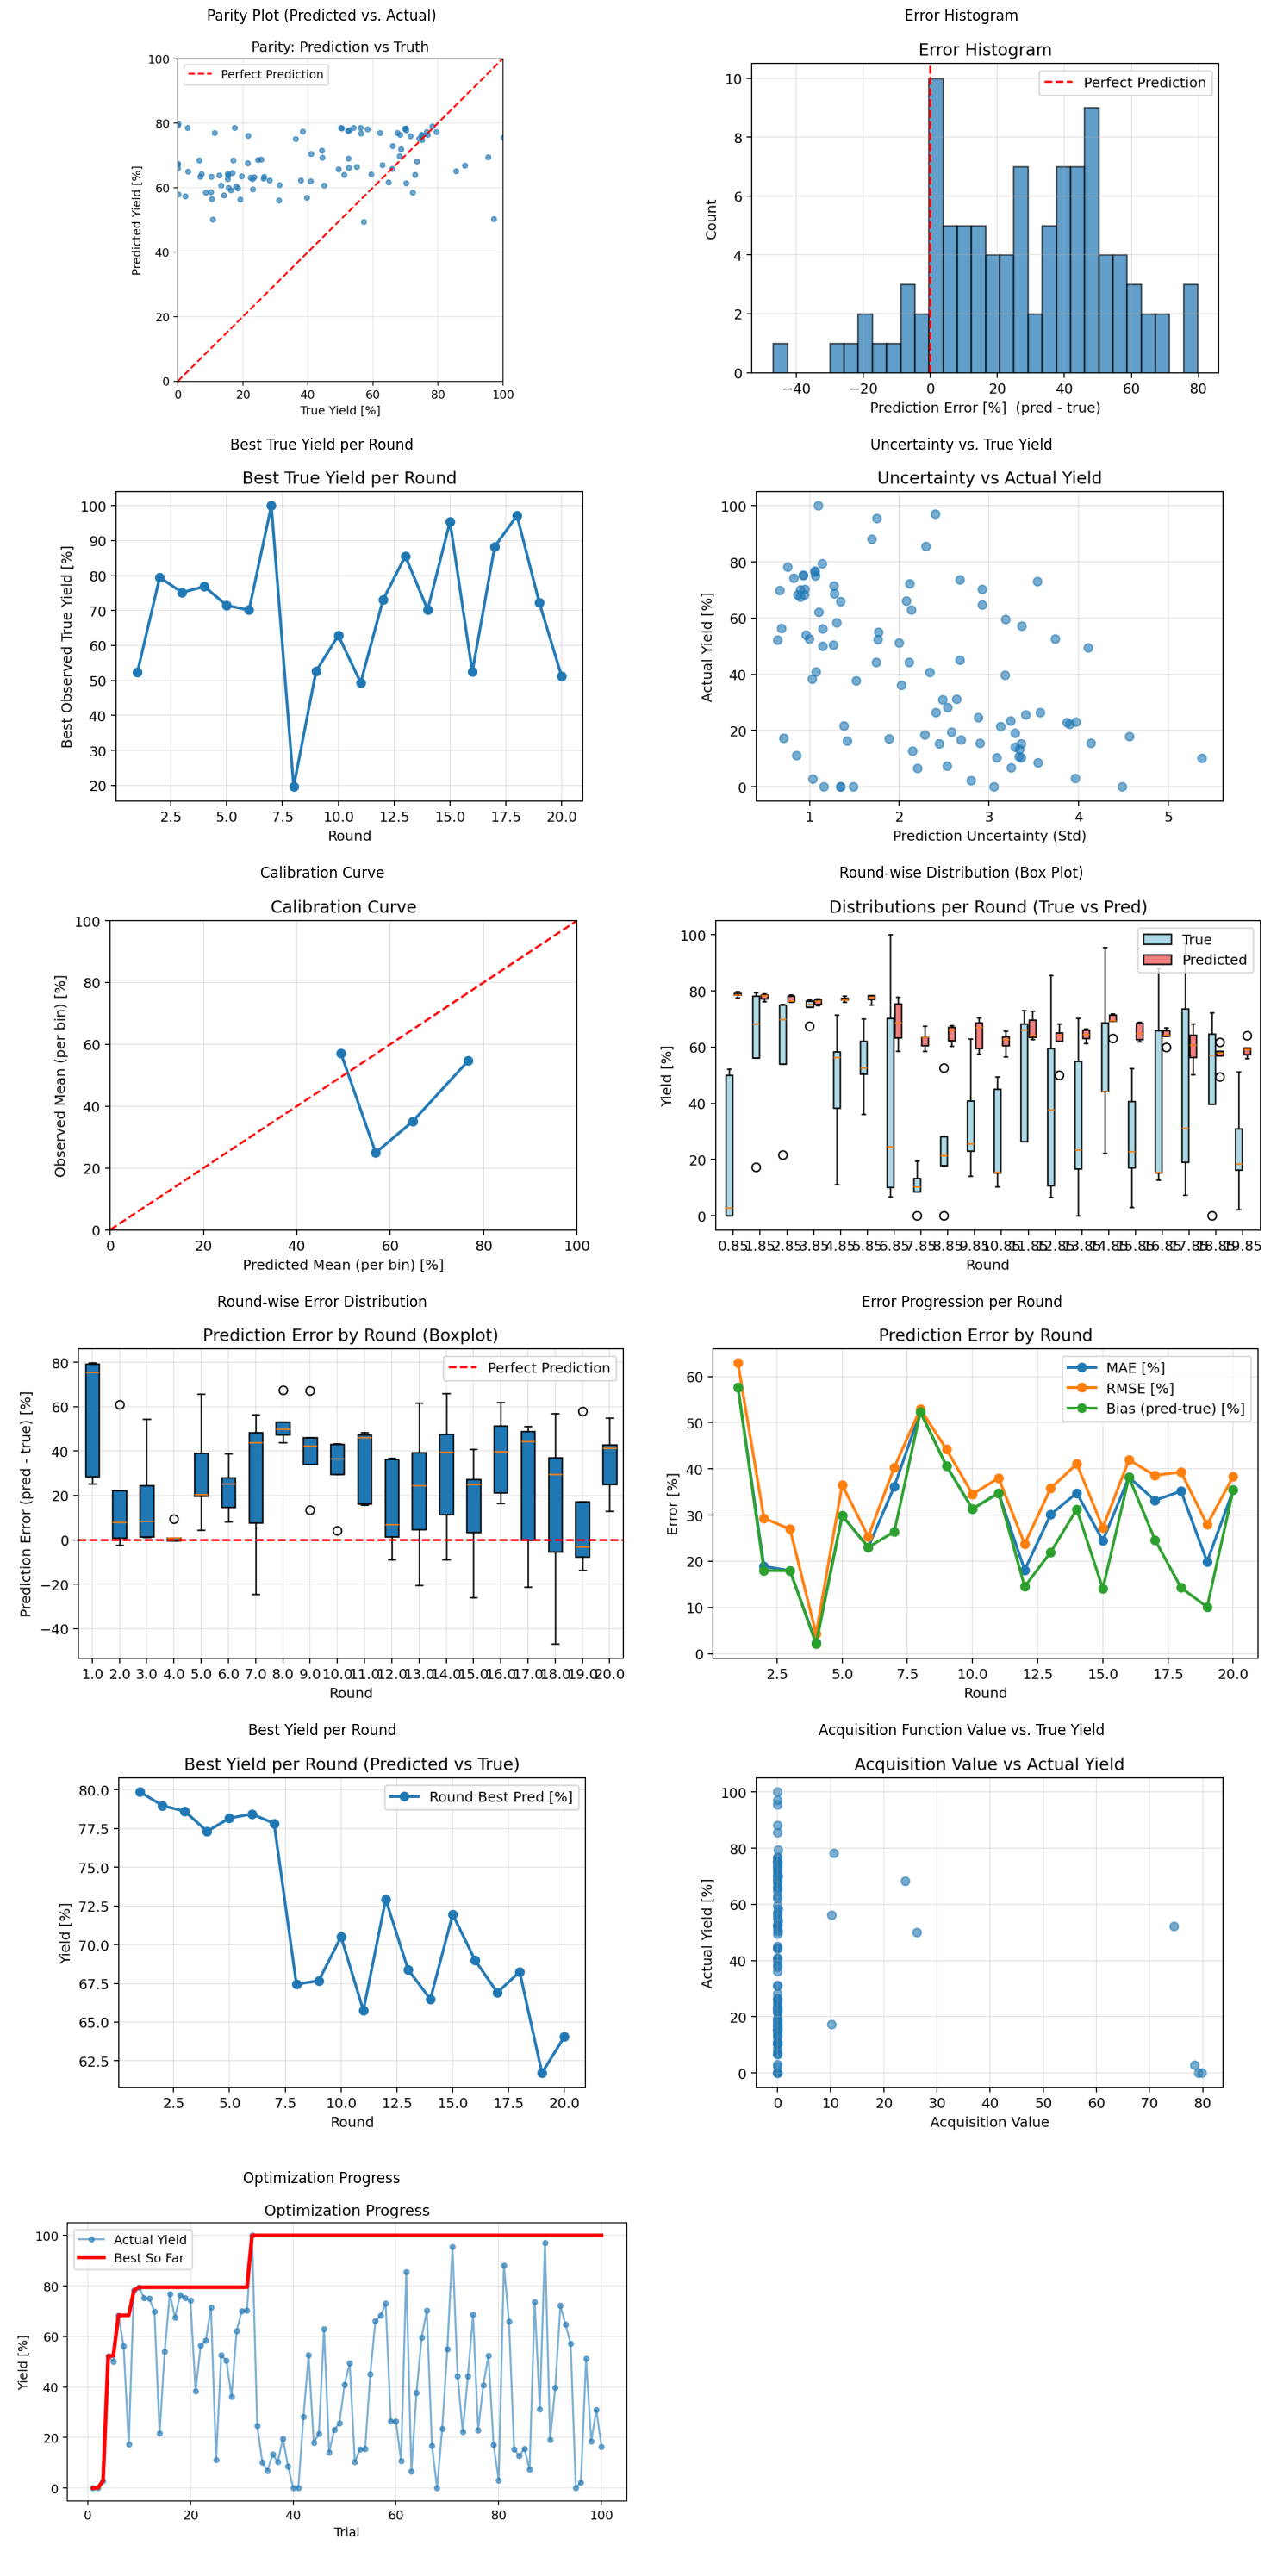

,n,mae_pct,rmse_pct,bias_pct,r2
0,100,30.73%,37.34%,26.93%,-0.841


,round,n,mae_pct,rmse_pct,bias_pct,r2
0,1,5,57.67%,62.94%,57.67%,-5.534
1,2,5,18.90%,29.33%,17.98%,-0.649
2,3,5,17.96%,26.96%,17.96%,-0.771
3,4,5,2.40%,4.27%,2.10%,-0.552
4,5,5,29.91%,36.53%,29.91%,-2.078
5,6,5,23.00%,25.36%,23.00%,-3.884
6,7,5,36.20%,40.33%,26.42%,-0.213
7,8,5,52.33%,52.96%,52.33%,-67.613
8,9,5,40.65%,44.23%,40.65%,-5.708
9,10,5,31.34%,34.53%,31.34%,-3.080


画像表示完了: runs/bayes_20rounds_5trials/visualization


In [27]:
result = visualize_and_display_logs('runs/bayes_20rounds_5trials/optimization_log.csv')